Combine overlays

- todo: make sure no target areas overlap with the AOI nor national boundary

In [188]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point, box, LineString
from shapely import intersection, difference
from tqdm.notebook import tqdm
# import glob

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r
target_epsg_verbose = "EPSG:6350"

In [15]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'
Aoi = gpd.read_parquet(fn_aoi).set_geometry('aoi').set_crs(epsg=target_epsg).rename(columns={'aoi':'geometry'})
Aoi.shape

(56, 1)

In [5]:
def read_overlay(fn, target_epsg=target_epsg):
    return gpd.read_parquet(fn).set_geometry('geometry').set_crs(epsg=target_epsg)

In [89]:
fn_coords = '/Volumes/Extreme SSD/largest_plots/clean_data/coords.parquet'
Coords = gpd.read_parquet(fn_coords).set_geometry('geometry').set_crs(epsg=target_epsg)

In [4]:
fn_water_area_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/water_area_overlay.parquet'
fn_water_linear_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/water_linear_overlay.parquet'
fn_roads_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/roads.parquet'
fn_rails_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/rails_overlay.parquet'
fn_nation_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/nation_overlay.parquet'

In [11]:
WaterAreaOverlay = read_overlay(fn_water_area_overlay)
WaterLinearOverlay = read_overlay(fn_water_linear_overlay)
RoadsOverlay = read_overlay(fn_roads_overlay)
RailsOverlay = read_overlay(fn_rails_overlay)
NationOverlay = read_overlay(fn_nation_overlay)

In [168]:
i = 30

<Axes: >

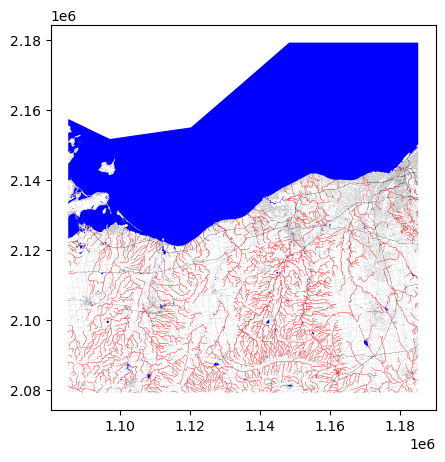

In [169]:
fig, ax = plt.subplots(figsize=(5, 5))
WaterAreaOverlay.loc[[i]].plot(ax=ax, color='blue')
WaterLinearOverlay.loc[[i]].plot(ax=ax, color='red')
RoadsOverlay.loc[[i]].plot(ax=ax, color='black')
RailsOverlay.loc[[i]].plot(ax=ax, color='green')
# NationOverlay.loc[[i]].plot(ax=ax, color='pink')

In [183]:
np.all(WaterAreaOverlay.index == Aoi.index)

True

In [184]:
np.all(WaterLinearOverlay.index == Aoi.index)

True

In [185]:
np.all(RailsOverlay.index == Aoi.index)

True

In [186]:
np.all(RoadsOverlay.index == Aoi.index)

True

In [187]:
np.all(NationOverlay.index == Aoi.index)

True

In [ ]:
target_area_dict = {}
valid_shape_dict = {}  # as qc, make sure no target areas overlap with the valid shape areas

for i in tqdm(Aoi.index):
    
    # Note the coordinates of the target point
    target_coord = Coords.loc[[i]]
    
    # valid ground is the intersection of AOI and nation
    valid_shape = intersection(Aoi.loc[i, 'geometry'], NationOverlay.loc[i, 'geometry'])
    
    # obstruction shape is the intersection of all boundaries
    obstruction_series = gpd.GeoSeries(
        pd.concat([
            WaterAreaOverlay.loc[i],
            WaterLinearOverlay.loc[i],
            RoadsOverlay.loc[i], 
            RailsOverlay.loc[i]
        ])
    )
    obstruction_shape = obstruction_series.unary_union
    
    # Find the valid ground that is not covered by obstructions. 
    # Store this as an exploded table (ie one row per polygon, rather than as a single multipolygon)
    # Returns the part of geometry A that does not intersect with geometry B.
    valid_intersection = difference(valid_shape, obstruction_shape)
    ValidIntersection = gpd.GeoDataFrame({'geometry':list(valid_intersection.geoms)}, crs=target_epsg_verbose)
    
    # Find the area that contains the target coordinate
    TargetArea = gpd.sjoin(left_df=ValidIntersection, right_df=target_coord, how='inner', predicate='contains')[['geometry']]

    # Store results
    target_area_dict[i] = TargetArea
    valid_shape_dict[i] = valid_shape

  0%|          | 0/56 [00:00<?, ?it/s]

In [197]:
target_area_dict

{0: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 1: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 2: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 3: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 4: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 5: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 6: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 7: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 8: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 9: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 10: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 11: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 12: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 13: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 14: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 15: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 16: Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 17: Empty GeoDataFrame
 Columns: [geomet

In [196]:
i = 10
target_area_dict[i]
# valid_shape_dict[i]

,geometry


In [170]:
# valid ground is the intersection of AOI and nation
valid_shape = intersection(Aoi.loc[i, 'geometry'], NationOverlay.loc[i, 'geometry'])

In [171]:
obstruction_series = gpd.GeoSeries(
    pd.concat([
        WaterAreaOverlay.loc[i],
        WaterLinearOverlay.loc[i],
        RoadsOverlay.loc[i], 
        RailsOverlay.loc[i]
    ])
)
obstruction_shape = obstruction_series.unary_union

In [172]:
# difference(a, b, grid_size=None, **kwargs)
# Returns the part of geometry A that does not intersect with geometry B.
valid_intersection = difference(valid_shape, obstruction_shape)
ValidIntersection = gpd.GeoDataFrame({'geometry':list(valid_intersection.geoms)}, crs=target_epsg_verbose)

In [173]:
np.round(obstruction_shape.area + valid_intersection.area) == np.round(valid_shape.area)

False

In [174]:
coord = Coords.loc[[i]]

In [175]:
TargetArea = gpd.sjoin(left_df=ValidIntersection, right_df=coord, how='inner', predicate='contains')[['geometry']]

In [176]:
x, y, nonsense_x, nonsense_y = coord.loc[i, 'geometry'].bounds


<Axes: >

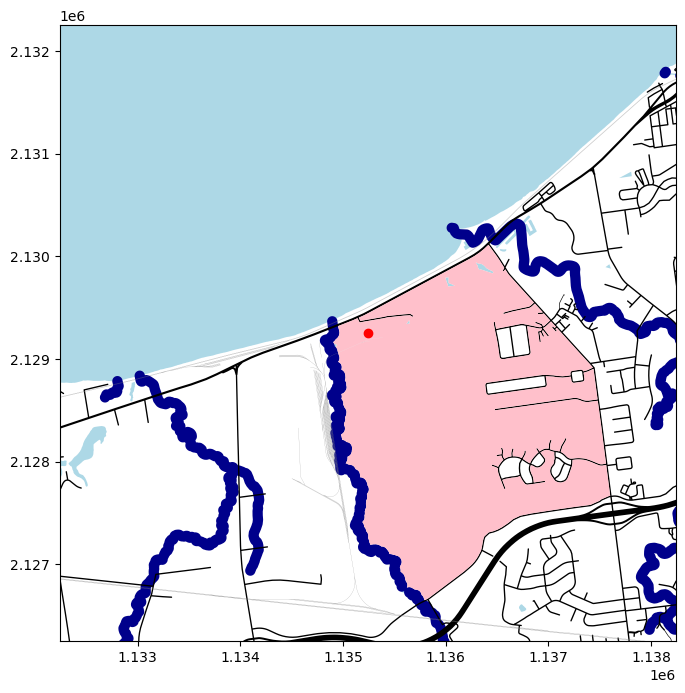

In [180]:
d = 3000
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim([x - d, x + d])
ax.set_ylim([y - d, y + d])

WaterAreaOverlay.loc[[i]].plot(ax=ax, color='lightblue')
WaterLinearOverlay.loc[[i]].plot(ax=ax, color='darkblue')
RoadsOverlay.loc[[i]].plot(ax=ax, color='black')
RailsOverlay.loc[[i]].plot(ax=ax, color='grey')
TargetArea.plot(ax=ax, color='pink')
coord.plot(ax=ax, color='red')

<Axes: >

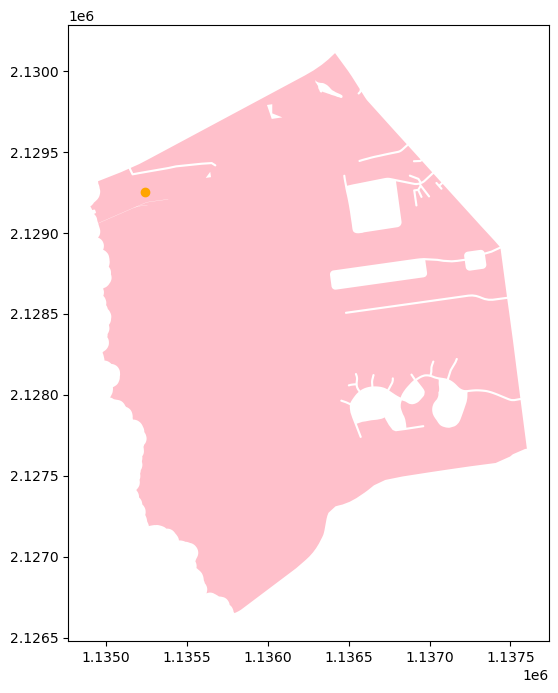

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))
TargetArea.plot(ax=ax, color='pink')
coord.plot(ax=ax, color='orange')

In [30]:
# gpd.GeoSeries([
    WaterAreaOverlay.loc[i], 
    WaterLinearOverlay.loc[i], 
    RoadsOverlay.loc[i], 
    RailsOverlay.loc[i], 
    NationOverlay.loc[i]])
# CollectedOverlays = gpd.GeoDataFrame(CollectedOverlays)

TypeError: Non geometry data passed to GeoSeries constructor, received data of dtype 'object'

In [29]:
CollectedOverlays

,0
0,"MULTIPOLYGON (((1064783.733 1236553.809, 10647..."
1,"MULTIPOLYGON (((1064783.733 1246651.126, 10647..."
2,"MULTIPOLYGON (((1064783.733 1251283.248, 10647..."
3,"MULTIPOLYGON (((1064783.733 1250048.001, 10645..."
4,"POLYGON ((1064783.733 1151341.503, 964783.733 ..."


In [28]:
CollectedOverlays.unary_union()

AttributeError: You are calling a geospatial method on the GeoDataFrame, but the active geometry column to use has not been set. 
There are columns with geometry data type ([0]), and you can either set one as the active geometry with df.set_geometry("name") or access the column as a GeoSeries (df["name"]) and call the method directly on it.